# Bagging

In [69]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import BaggingClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [1]:
# Tengo que recargar el archivo para que tome los cambios que se hicieron en el mismo
import importlib, sys

#importlib.reload(sys.modules['Preprocessing'])
from Preprocessing import *

In [2]:
df = generate_initial_dataset(df_data, df_decision)
df = replace_nulls_edad(df, 'mediana')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,31.0,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,31.0,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [72]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,31.0,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,31.0,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


# Entrenamiento

In [73]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [74]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2
2,0,1,0,794,0,1,31.0,0,0,3,0,1,0,0
3,0,0,1,455,0,1,31.0,0,0,1,0,1,1,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2


In [75]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [76]:
y.sum()

307

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

In [78]:
y_train.value_counts()

0    367
1    233
Name: volveria, dtype: int64

In [79]:
y_test.value_counts()

0    127
1     74
Name: volveria, dtype: int64

### Random Search

In [80]:
params = {'max_samples': np.arange(1, 50), 
          'max_features': np.arange(1, 25),
          'n_estimators': np.arange(1, 50),
         }

model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117
)

rgscv = RandomizedSearchCV(
    model_bagging, params, n_iter=60, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train, y_train)

In [81]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8306134261439471
Best params {'n_estimators': 44, 'max_samples': 30, 'max_features': 10}


In [82]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = StratifiedKFold(n_splits=5)

test_rocs = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    bagging = BaggingClassifier(
        base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
        n_estimators = rgscv.best_params_['n_estimators'],
        max_samples = rgscv.best_params_['max_samples'],
        max_features = rgscv.best_params_['max_features'],
        random_state = 117
    )
    bagging.fit(X.iloc[train_index], y.iloc[train_index])
    test_roc = roc_auc_score(y.iloc[test_index], bagging.predict(X.iloc[test_index]))
    print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
    test_rocs.append(test_roc)
print(f"Mean test AUC ROC is: {np.mean(test_rocs):.4f}")

Fold 0: AUC ROC score is 0.7610
Fold 1: AUC ROC score is 0.6910
Fold 2: AUC ROC score is 0.7887
Fold 3: AUC ROC score is 0.7099
Fold 4: AUC ROC score is 0.7202
Mean test AUC ROC is: 0.7342


## AUC ROC

In [83]:
roc = roc_auc_score(y_test, bagging.predict_proba(X_test)[:,1])
print(f"{roc:.4f}")

0.8650


## Accuracy

In [84]:
acc = accuracy_score(y_test, bagging.predict(X_test))
print(f"{acc:.4f}")

0.7910


## Precision

In [85]:
precision = precision_score(y_test, bagging.predict(X_test))
print(f"{precision:.4f}")

0.7963


## Recall

In [86]:
recall = recall_score(y_test, bagging.predict(X_test), pos_label=0)
print(f"{recall:.4f}")

0.9134


## F1-Score

In [87]:
f1 = f1_score(y_test, bagging.predict(X_test))
print(f"{f1:.4f}")

0.6719


## Matriz de Confusión

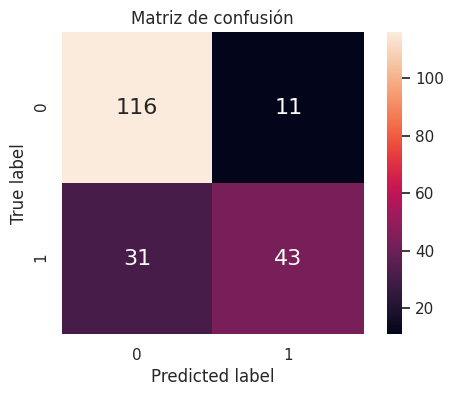

In [88]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusión")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, bagging.predict(X_test))

## Test Holdout

In [89]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
holdout.head(5)

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


In [90]:
df_h = generate_holdout_dataset(holdout)
df_h = replace_nulls_edad(df_h, 'mediana')
df_h = encodear_atributos_categoricos(df_h)
df_h = df_h.drop(['volveria'], axis=1)
df_h.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,650,0,1,26.0,0,0,1,0,0,1,0
1,0,0,1,234,0,1,8.0,4,2,4,0,0,1,6
2,0,1,0,31,1,0,43.0,0,0,3,0,1,0,0
3,0,1,1,552,1,0,30.0,0,0,3,0,0,1,0
4,0,0,1,411,1,0,32.0,0,0,1,0,0,1,0


In [91]:
y_pred = bagging.predict(df_h)
y_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1])

In [92]:
(y_pred.shape, df_h.shape)

((90,), (90, 14))

In [93]:
serie_predicha = pd.Series(y_pred, name='volveria') 
serie_predicha = serie_predicha.to_frame()
serie_predicha.head(10)

,volveria
0,0
1,0
2,1
3,1
4,0
5,0
6,0
7,0
8,1
9,0


In [94]:
df_predicho = holdout.join(serie_predicha, how='inner')
cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,1
3,552,1
4,411,0


In [95]:
df_resultado.shape

(90, 2)

In [96]:
df_resultado.to_csv('prediccion/Bagging_resultado_final.csv')